# Analyze Genome Taxonomy Database r214

This notebook analyzes predicted conditions for all representative species in the Genome Taxonomy Database

In [42]:
import pandas as pd
from glob import glob
from collections import Counter

from matplotlib.colors import LinearSegmentedColormap
import string
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../")
from genome_spot.helpers import rename_condition_to_variable
plt.rcParams['svg.fonttype'] = 'none'

plt.style.use('project.mplstyle')

In [52]:
plot_formats = {
    'oxygen' : 'Oxygen',
    'temperature' : 'Temperature',
    'ph' : 'pH',
    'salinity' : 'Salinity',
    'temperature_optimum' : 'Temperature, Optimum ',
    'ph_optimum' : 'pH, Optimum',
    'salinity_optimum' : 'Salinity, Optimum',
}
units = {
    'temperature' : u'\N{DEGREE SIGN}C',
    'ph' : 'pH',
    'salinity' : '% w/v NaCl',
    'oxygen' : 'Probability Oxygen Tolerant'
}


In [3]:
targets = ['oxygen', 'temperature_optimum', 'salinity_optimum', 'ph_optimum']

bin_definitions = {
    'oxygen' : [0, 0.5],
    'ph_optimum' : np.arange(3,12,1),
    'temperature_optimum' : [0,15,30,45,60,80],
    'salinity_optimum' : [0, 0.5, 1, 2.5, 5, 10, 15],
}
oxygen_colors = ['dimgray', 'whitesmoke', 'skyblue']
oxygen_colors = ['#0E95C8',   '#F8A483'] #'whitesmoke',
oxygen_colors = [plt.get_cmap("RdBu_r")(0.15),   plt.get_cmap("RdBu_r")(0.83)] # plt.get_cmap("RdBu_r")(0.5),
oxygen_cmap = LinearSegmentedColormap.from_list('my_cmap', oxygen_colors, N=3)

cmap_definitions = {target : plt.get_cmap("RdBu_r") for target in targets}
cmap_definitions['oxygen'] = oxygen_cmap

In [4]:
# Phylogenetic order, obtained from elsewhere
# You can also just set this to the index if you don't want it to be biologically sorted
phylum_order = ['UBA6262', 'Elusimicrobiota', 'RUG730', 'CG03', 'GCA_021790555', 'CAKKQC01', 'FCPU426', 'JAAXVQ01', 'Firestonebacteria', 'Goldbacteria', 'Aerophobota', 'CAIJMQ01', 'GCA_016783345', 'NPL-UPA2', 'JAHJDO01', 'Ratteibacteria', 'Omnitrophota', 'GCA-001730085', 'GCA_022711655', 'GCA_012729785', 'PUNC01', 'UBA3054', 'JABMQX01', 'UBA6266', 'Auribacterota', 'JAFGBW01', 'JACPWU01', 'JACRDZ01', 'UBA9089', 'UBP18', 'Desantisbacteria', 'Sumerlaeota', 'OLB16', 'Abyssobacteria', 'Hydrogenedentota', 'GCA_002428325', 'Poribacteria', 'RBG-13-66-14', 'Fermentibacterota', 'Fibrobacterota', 'GCA_017997825', 'AABM5-125-24', 'Delongbacteria', 'Calditrichota', 'KSB1', 'JdFR-76', 'QNDG01', 'GCA_016783505', 'SM23-31', 'CLD3', 'Bacteroidota', 'Marinisomatota', 'Cloacimonadota', 'UBP14', 'GCA_016927185', 'WOR-3', 'TA06_A', 'JAAXHH01', 'Latescibacterota', 'GCA_023135015', 'Zixibacteria', 'VGIX01', 'JABDJQ01', 'ARS69', 'GCA_023132135', 'Eisenbacteria', 'Krumholzibacteriota', 'GCA_002686955', 'Gemmatimonadota', '4572-55', 'Edwardsbacteria', 'TA06', 'Acidobacteriota', 'B130-G9', 'CSSED10-310', 'Campylobacterota', 'Aquificota', 'Thermosulfidibacterota', 'Chrysiogenota', 'Deferribacterota', 'Desulfobacterota_D', 'GCA_024275095', 'Calescibacterota', 'GCA_020722945', 'Desulfobacterota_G', 'JAMCPX01', 'SZUA-79', 'GCA_003695505', 'Pseudomonadota', 'UBA2233', 'Nitrospirota_A', 'Desulfobacterota_E', 'BMS3Abin14', 'Desulfobacterota_C', 'Desulfobacterota_F', 'SZUA-182', 'Moduliflexota', 'Methylomirabilota', 'Schekmanbacteria', 'UBA8248', 'GCA_016192455', 'GCA_022562795', 'GCA_016193065', 'Tectomicrobia', 'Nitrospinota_B', 'Nitrospinota', 'CG2-30-53-67', 'GCA_016212085', 'CG2-30-70-394', 'Nitrospirota', 'Desulfobacterota', 'UBA10199', 'GCA_016202395', 'JACPQY01', 'RBG-13-61-14', 'GCA_003598065', 'FEN-1099', 'Myxococcota', 'GCA_020434085', 'GCA_016713535', 'Myxococcota_A', 'Desulfobacterota_B', 'UBP6', 'SAR324', 'Bdellovibrionota', 'Planctomycetota', 'Chlamydiota', 'Verrucomicrobiota', 'UBA8481', 'Lindowbacteria', 'T1Sed10-126', 'Dependentiae', 'GCA_017999075', 'GCA_003554345', 'AUK180', 'Spirochaetota', 'Bipolaricaulota', 'Deinococcota', 'Patescibacteria', '4484-113', 'UBP15', 'UBP7', 'Riflebacteria', 'UBP17', 'Muirbacteria', 'Wallbacteria', 'Mcinerneyibacteriota', 'Fusobacteriota', 'Synergistota', 'Atribacterota', 'Thermotogota', 'DUMJ01', 'Dictyoglomota', 'JACIXR01', 'DRYD01', 'Thermodesulfobiota', 'HKB111', 'Coprothermobacterota', 'JANLFM01', 'Caldisericota', 'Cyanobacteriota', 'Margulisbacteria', 'Actinomycetota', 'CSP1-3', 'Dormibacterota', 'Chloroflexota', 'GCA_002410925', 'Armatimonadota', 'Eremiobacterota', 'Bacillota_E', 'Bacillota_G', 'Bacillota_F', 'GCA_012840065', 'Bacillota_A', 'Bacillota_C', 'Bacillota_B', 'Bacillota_D', 'Bacillota', 'Bacillota_H', 'GCA_007132905', 'DTU030', 'GCA_002789275', 'Aenigmatarchaeota', 'Nanohaloarchaeota', 'EX4484-52', 'Nanoarchaeota', 'SpSt-1190', 'GCA_013154095', 'Undinarchaeota', 'Micrarchaeota', 'B1Sed10-29', 'Iainarchaeota', 'Altiarchaeota', 'Thermoproteota', 'Asgardarchaeota', 'Thermoplasmatota', 'Halobacteriota', 'Methanobacteriota_B', 'Hadarchaeota', 'Methanobacteriota', 'Hydrothermarchaeota', 'GCA_024860865']
print(phylum_order)

['UBA6262', 'Elusimicrobiota', 'RUG730', 'CG03', 'GCA_021790555', 'CAKKQC01', 'FCPU426', 'JAAXVQ01', 'Firestonebacteria', 'Goldbacteria', 'Aerophobota', 'CAIJMQ01', 'GCA_016783345', 'NPL-UPA2', 'JAHJDO01', 'Ratteibacteria', 'Omnitrophota', 'GCA-001730085', 'GCA_022711655', 'GCA_012729785', 'PUNC01', 'UBA3054', 'JABMQX01', 'UBA6266', 'Auribacterota', 'JAFGBW01', 'JACPWU01', 'JACRDZ01', 'UBA9089', 'UBP18', 'Desantisbacteria', 'Sumerlaeota', 'OLB16', 'Abyssobacteria', 'Hydrogenedentota', 'GCA_002428325', 'Poribacteria', 'RBG-13-66-14', 'Fermentibacterota', 'Fibrobacterota', 'GCA_017997825', 'AABM5-125-24', 'Delongbacteria', 'Calditrichota', 'KSB1', 'JdFR-76', 'QNDG01', 'GCA_016783505', 'SM23-31', 'CLD3', 'Bacteroidota', 'Marinisomatota', 'Cloacimonadota', 'UBP14', 'GCA_016927185', 'WOR-3', 'TA06_A', 'JAAXHH01', 'Latescibacterota', 'GCA_023135015', 'Zixibacteria', 'VGIX01', 'JABDJQ01', 'ARS69', 'GCA_023132135', 'Eisenbacteria', 'Krumholzibacteriota', 'GCA_002686955', 'Gemmatimonadota', '45

# Load data


## GTDB

In [5]:

DIR_DATA = '/Users/tylerbarnum/cultivarium/tyler-analysis/data/'
GTDB_TAXONOMY_TABLES = [f'{DIR_DATA}/strain-selection/ar53_metadata_r214.tsv', 
                        f'{DIR_DATA}/strain-selection/bac120_metadata_r214.tsv']
RANKS = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
def strains_to_species(strains : list):
    species = []
    for strain in strains:
        split = strain.split()
        if len(split) == 0:
            species.append('')
        elif len(split) == 1:
            species.append(split[0])
        elif split[1] == 'sp.':
            species.append(' '.join(split[0:3]))
        else:
            species.append(' '.join(split[0:2]))
    return species
    
def gtdb_accession_to_ncbi(accession : str, 
                           make_genbank : bool = True, 
                           remove_version : bool = True) -> str:
    """Convert GTDB 'accession' into NCBI accession.

    Options allow different formats.

    Args:
        accession: GTDB accession e.g. RS_GCF_016456235.1
        make_genbank: Replace the initial 'GCF_' with 'GCA_'
        remove_version: Remove the terminal '.#'
    Returns:
        ncbi_accession : NCBI accession e.g. GCA_016456235
    """

    ncbi_accession = accession[3:]
    if make_genbank:
        ncbi_accession = ncbi_accession.replace('GCF_', 'GCA_')
    if remove_version:
        ncbi_accession = ncbi_accession[:-2]
    return ncbi_accession


def load_gtdb_df(genomic_metadata_paths : list,
                 simple=True):

    
    df_gtdb = pd.concat([pd.read_csv(tsv, sep='\t', header=0) for tsv in genomic_metadata_paths], axis=0) 

    if simple == True:
        retain_columns = {'accession' : str, 'ncbi_taxid' : int, 'ncbi_genbank_assembly_accession' : str,
                      'ncbi_taxonomy' : str,  'gtdb_taxonomy' : str,  'gtdb_genome_representative' : str, 
                     }
        df_gtdb = df_gtdb.loc[:, retain_columns.keys()]
        
    
    df_taxonomy = df_gtdb['gtdb_taxonomy'].str.split(';', expand=True)
    df_taxonomy.columns = RANKS
    df_gtdb = pd.concat([df_gtdb, df_taxonomy], axis=1)

    strains = [taxonomy.split(';')[-1][3:] for taxonomy in df_gtdb['ncbi_taxonomy']]
    df_gtdb['ncbi_species'] =  strains_to_species(strains)
    df_gtdb['ncbi_accession'] = df_gtdb['accession'].apply(lambda x : gtdb_accession_to_ncbi(x)) 
    df_gtdb['representative_ncbi_accession'] = df_gtdb['gtdb_genome_representative'].apply(lambda x : gtdb_accession_to_ncbi(x)) 
    df_gtdb = df_gtdb.set_index('accession')
    #df_gtdb['ncbi_genus'] = df_gtdb['genus'].str[3:]
    return df_gtdb

gtdb_df = load_gtdb_df(genomic_metadata_paths=GTDB_TAXONOMY_TABLES, simple=False)
gtdb_df.head(1)

,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,contig_count,...,domain,phylum,class,order,family,genus,species,ncbi_species,ncbi_accession,representative_ncbi_accession
accession,,,,,,,,,,,,,,,,,,,,,
GB_GCA_000008085.1,0,73.13,0.0,149,k__Archaea (UID2),107,0.0,462902,94.29948,1,...,d__Archaea,p__Nanoarchaeota,c__Nanoarchaeia,o__Nanoarchaeales,f__Nanoarchaeaceae,g__Nanoarchaeum,s__Nanoarchaeum equitans,Nanoarchaeum equitans,GCA_000008085,GCA_000008085


In [6]:
gtdb_df['ncbi_genome_category'].value_counts()

ncbi_genome_category
none                                 276424
derived from metagenome              118167
derived from environmental sample      7222
derived from single cell                896
Name: count, dtype: int64

## Features or Predictions

In [7]:
# json.loads(open('data/features/GCA_0043637251.features.json').read()).keys()
# filename = 'data/features/GCA_0043637251.features.json'

def load_genome(filename):
    flatten_by_localization = False
    # FIX: misnamed genome
    #genome = filename.split('/')[-1].split('.')[0][:-1]
    genome = filename.split('/')[-1].split('.')[0].replace('GCF_', 'GCA_')

    sers = []
    json_df = pd.read_json(filename)
    for col in json_df.columns:
        ser = json_df.loc[:, col]
        ser.name = genome
        index_tuples = list(zip([col] * len(ser), ser.index.tolist()))
        index = pd.MultiIndex.from_tuples(index_tuples, names=["localization", "variable"])
        ser.index = index
        sers.append(ser)
        
    df_genome = pd.concat(sers, axis=0)
    return df_genome

def load_features_to_dataframe(features_dir):
    sers = []
    for filename in glob(features_dir + '*.features.json'):
        ser_genome = load_genome(filename)
        sers.append(ser_genome)
    df_features = pd.concat(sers, axis=1).T

    # Missing data should be 0
    df_features = df_features.fillna(0.)

    renamed_cols = ['_'.join(ser) for ser in df_features]
    df_features.columns = df_features.columns.droplevel()
    df_features.columns = renamed_cols

    return df_features
    
FEATURES_DIRECTORY = '/Users/tylerbarnum/cultivarium/external/gtdb/r214/features-v4/'
df_features = load_features_to_dataframe(features_dir = FEATURES_DIRECTORY) 
df_features

,all_nt_length,all_pur_pyr_transition_freq,all_nt_C,all_nt_A,all_total_proteins,all_total_protein_length,all_pis_acidic,all_pis_neutral,all_pis_basic,all_pis_3_4,...,diff_extra_intra_aa_CE,diff_extra_intra_aa_CH,diff_extra_intra_aa_CC,diff_extra_intra_aa_CM,diff_extra_intra_aa_WF,diff_extra_intra_aa_CW,diff_extra_intra_aa_CR,diff_extra_intra_aa_WM,diff_extra_intra_aa_WC,diff_extra_intra_protein_coding_density
GCA_945865315,3268622.0,0.469597,0.330090,0.669910,2558.0,929727.0,0.183346,0.386630,0.430023,0.0,...,0.000399,0.000000,6.298325e-04,0.000025,-0.000096,0.000000,-0.000712,-0.000192,-5.006350e-05,0.0
GCA_019668465,5831457.0,0.537898,0.670763,0.329237,5391.0,1757505.0,0.479132,0.315711,0.205157,0.0,...,0.000058,0.000116,-2.483916e-05,-0.000010,0.000077,-0.000071,-0.000171,-0.000053,6.957338e-05,0.0
GCA_022013695,2613105.0,0.442826,0.396957,0.603043,2423.0,780823.0,0.267850,0.375567,0.356583,0.0,...,-0.000515,-0.000198,-1.586728e-04,0.000000,-0.000038,-0.000020,-0.000294,-0.000090,-9.479255e-07,0.0
GCA_025059875,1974558.0,0.485886,0.595108,0.404892,1707.0,620846.0,0.144112,0.484476,0.371412,0.0,...,-0.000318,-0.000261,0.000000e+00,0.000000,-0.000065,-0.000111,-0.000804,0.000154,1.114702e-04,0.0
GCA_019419625,2072323.0,0.525415,0.600922,0.399078,1819.0,600860.0,0.611875,0.252336,0.135789,0.0,...,-0.000947,-0.000258,-2.355708e-04,-0.000256,-0.000024,-0.000103,-0.000729,-0.000072,-9.679650e-05,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_021841985,3257789.0,0.524262,0.673289,0.326711,3258.0,988182.0,0.169429,0.477594,0.352977,0.0,...,-0.000326,-0.000082,-2.248155e-07,-0.000032,0.000204,-0.000036,-0.000166,0.000075,-2.156741e-06,0.0
GCA_016124805,3211684.0,0.513014,0.588922,0.411078,3058.0,966221.0,0.365271,0.419882,0.214846,0.0,...,-0.000115,0.000007,-7.163805e-05,0.000012,-0.000136,-0.000016,-0.000091,-0.000027,-8.972135e-06,0.0
GCA_019241735,2619215.0,0.493309,0.560916,0.439084,2730.0,784389.0,0.173260,0.452381,0.374359,0.0,...,-0.000532,-0.000308,-4.706602e-05,-0.000112,-0.000203,-0.000055,-0.000336,-0.000008,-8.431379e-05,0.0
GCA_000518885,5558881.0,0.450615,0.406261,0.593739,5525.0,1503079.0,0.364706,0.358190,0.277104,0.0,...,-0.000675,-0.000204,0.000000e+00,-0.000166,-0.000014,-0.000086,-0.000383,-0.000014,-1.221333e-05,0.0


In [8]:
# df_features[[col for col in df_features.columns if col.startswith('all') and len(col.split('aa_')[-1]) != 2]].to_csv('gtdb_features_subset_20231203.tsv' , sep='\t')

In [118]:
# Optima
from collections import defaultdict
PATH_TO_PREDICTIONS = '/Users/tylerbarnum/cultivarium/external/gtdb/r214/predictions-v7' 

def oxygen_value_error_to_prob(value, error):
    """Convert to legacy format for analysis"""
    if value == "tolerant":
        probability = error
    else:
        probability = 1 - error
    return probability

novel_for_target = defaultdict(list)

        
sers = []
for tsv in glob(f"{PATH_TO_PREDICTIONS}/*.predictions.tsv"):
    accession = gtdb_accession_to_ncbi(f"123{tsv.split('/')[-1]}".split('.')[0], remove_version=False)
    try:
        predictions_df = pd.read_csv(tsv, sep='\t', index_col=0)
        value = predictions_df.loc['oxygen', 'value']
        error = predictions_df.loc['oxygen', 'error']
        ser = predictions_df['value']
        ser.at['oxygen'] = oxygen_value_error_to_prob(value, error)
        ser = ser.astype(float)
        ser.name = accession
        sers.append(ser)
        
        for target in targets:
            is_novel = dict(predictions_df.loc[:, 'is_novel']).get(target, False)
            if is_novel is True:
                novel_for_target[target].append(accession)
    except:
        pass

optima_df = pd.concat(sers,axis=1).T
optima_df

target,oxygen,ph_max,ph_min,ph_optimum,salinity_max,salinity_min,salinity_optimum,temperature_max,temperature_min,temperature_optimum
GCA_902362725,0.000220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_020724205,0.035509,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
GCA_007095845,0.688361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_019747905,0.824845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_015492245,0.000067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
GCA_016870115,0.893629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_900411375,0.999399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_022361195,0.973567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_007117945,0.986273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
optima_df.sum()

target
oxygen                 46537.003704
ph_max                  3806.000000
ph_min                  3806.000000
ph_optimum              3806.000000
salinity_max            7865.000000
salinity_min            7865.000000
salinity_optimum        7865.000000
temperature_max         4834.000000
temperature_min         4834.000000
temperature_optimum     4834.000000
dtype: float64

In [117]:
dict(predictions_df.loc[:, 'is_novel']).get(target)

False

In [112]:
targets

['oxygen', 'temperature_optimum', 'salinity_optimum', 'ph_optimum']

{'oxygen': False,
 'ph_max': False,
 'ph_min': False,
 'ph_optimum': False,
 'salinity_max': False,
 'salinity_min': False,
 'salinity_optimum': False,
 'temperature_max': False,
 'temperature_min': False,
 'temperature_optimum': False}

In [9]:
predictions_df.reset_index().columns

Index(['target', 'value', 'error', 'units', 'is_novel', 'warning'], dtype='object')

In [10]:
df = pd.merge(optima_df, gtdb_df.set_index('ncbi_accession'), left_index=True, right_index=True, how='left')
df.shape

(84844, 128)

# Validation: Cultivated vs. Uncultivated Organisms in Family

- Finds families with both cultivated and uncultivated genomes
- Compares average predictions between those groups
- Each point in the scatter is a family

In [11]:
rank = 'family'

In [12]:
is_isolate = (df['ncbi_genome_category'] == 'none')
taxa_with_isolate = set(df[is_isolate][rank].drop_duplicates().tolist())
taxa_with_uncultivated = set(df[~is_isolate][rank].drop_duplicates().tolist())
taxa_to_compare = taxa_with_isolate.intersection(taxa_with_uncultivated)

print("# families=", len(taxa_to_compare))

# families= 820


In [13]:
df_compare = df[df[rank].isin(taxa_to_compare)].copy()
df_compare['is_isolate'] = (df_compare['ncbi_genome_category'] == 'none')
df_compare['count'] = 1
df_compare['n_isolate'] = (df_compare['ncbi_genome_category'] == 'none')
df_sum = df_compare.groupby([rank, 'is_isolate'])[targets + ['n_isolate', 'count']].sum().reset_index()
df_compare = df_compare.groupby([rank, 'is_isolate'])[targets + ['n_isolate']].mean().reset_index()


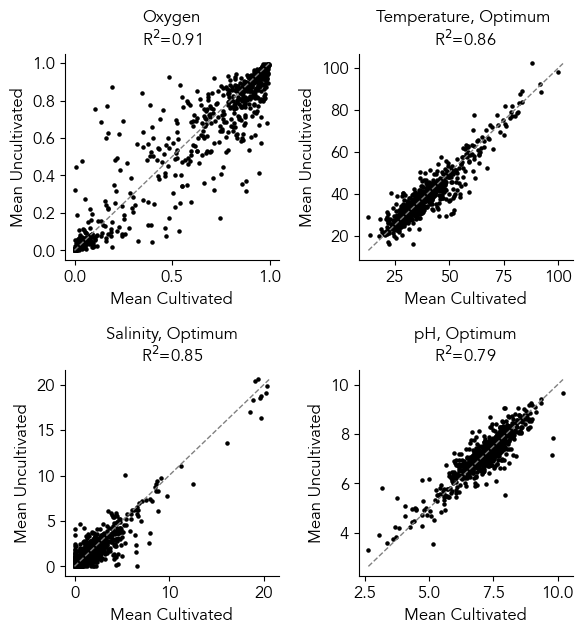

In [82]:
from sklearn.metrics import r2_score
target = 'salinity_optimum'

#fig, axes = plt.subplots(4,1,figsize=(3,13))
fig, axes = plt.subplots(2,2,figsize=(6,6.5))
axl = axes.flatten()

for n, target in enumerate(targets):
    ax = axl[n]
    df_plot = pd.pivot(df_compare, index='family', columns='is_isolate', values=target)
    


    xmin, xmax = df_plot.min().min(), df_plot.max().max()
    X = df_plot[True]
    Y = df_plot[False]

    #r = df_plot.corr(method='pearson').iloc[0,1]    
    r2 = r2_score(X,Y)
    ax.scatter(X, Y, s=5)
    ax.plot([xmin, xmax], [xmin,xmax], linestyle='--', color='gray')
    ax.set_title(plot_formats[target] + f'\nR$^2$={r2:.2f}')
    ax.set_xlabel('Mean Cultivated')
    ax.set_ylabel('Mean Uncultivated')
    
plt.tight_layout()


df_stats = df_sum.groupby('family').mean()
1 - np.mean(df_stats['n_isolate'] / df_stats['count']), 1 - np.min(df_stats['n_isolate'] / df_stats['count']), 1- np.max(df_stats['n_isolate'] / df_stats['count'])
plt.savefig("fig-3A.svg",  format="svg")
plt.show()

In [15]:

df_stats = df_sum.groupby('family').mean()
print("Average uncultivated fraction=", 1 - np.mean(df_stats['n_isolate'] / df_stats['count']))
print("Min uncultivated fraction=", 1 - np.min(df_stats['n_isolate'] / df_stats['count']))
print("Max uncultivated fraction=", 1 - np.max(df_stats['n_isolate'] / df_stats['count']))

Average uncultivated fraction= 0.6196378980974593
Min uncultivated fraction= 0.9974025974025974
Max uncultivated fraction= 0.005876591576885359


# Distribution

oxygen
temperature_optimum
salinity_optimum
ph_optimum


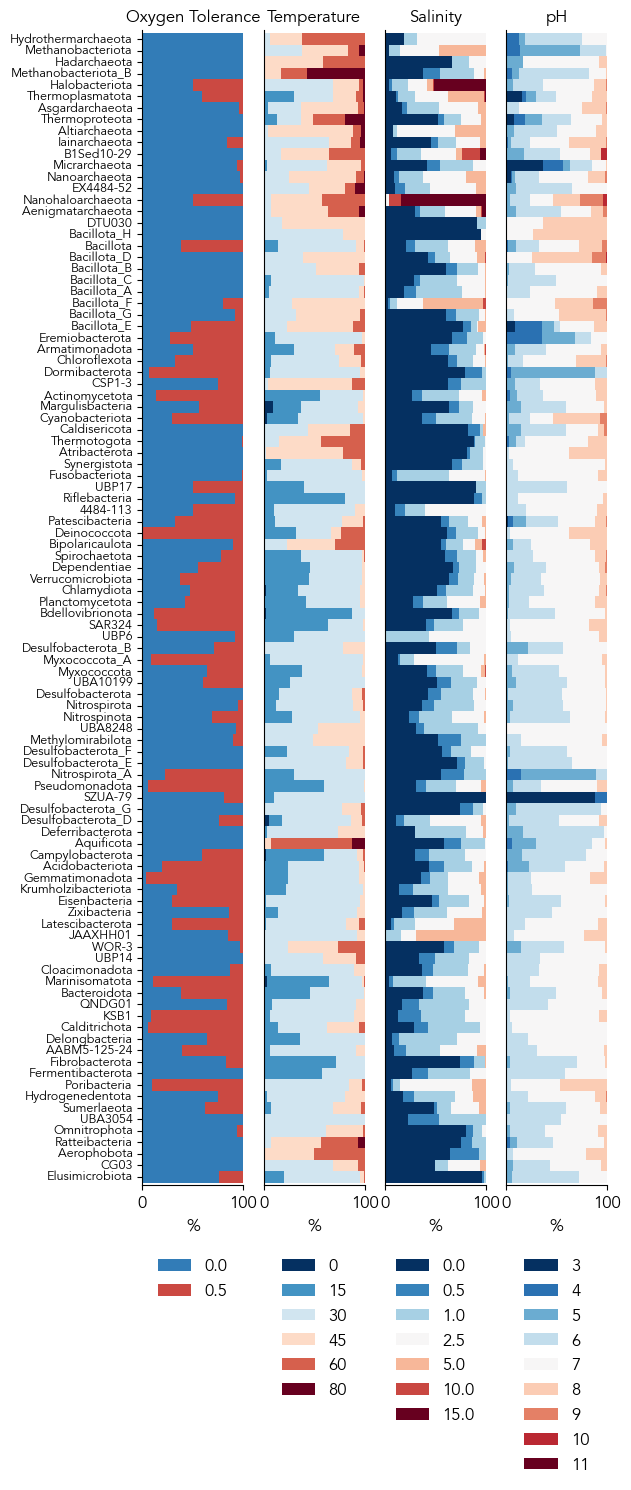

In [16]:
MIN_SPECIES_PER_PHYLUM = 10 

def distribution_df_by_target(target, df=df, taxonomic_level='phylum', normalize=True):
    
    sers = []
    bins = bin_definitions[target]
    for name, group in df.groupby(taxonomic_level):
        genome_ids = group.index.tolist()
        if len(genome_ids) > 0:
            values = df.reindex(genome_ids)[target].dropna()
            values.loc[values < bins[0]] = bins[0]
            binned_values = np.digitize(values, bins) - 1
            binned_ser = pd.Series(Counter(binned_values))
            binned_ser.name = name
            #binned_ser.index = range(len(bins) - 1)
            #binned_ser[0] = binned_ser.map(Counter(binned_values))
            sers.append(binned_ser)
    
    n_bins = len(bins) - 1
    blank_ser = pd.Series(dict(zip(range(n_bins), [0] * n_bins)))
    blank_ser.name = -1
    sers.append(blank_ser)
    
    dist_df = pd.DataFrame(sers).fillna(0).drop(-1)
    if normalize is True:
        dist_df = (dist_df.T / dist_df.sum(axis=1)).T
    dist_df = dist_df.T.sort_index().T
    return dist_df

fig, axes = plt.subplots(1,4, figsize=(6,15))

for n, target in enumerate(targets):
    ax = axes[n]
    dist_df = distribution_df_by_target(target, normalize=False)
    dist_df = dist_df[dist_df.sum(axis=1) >= MIN_SPECIES_PER_PHYLUM]
    dist_df = (dist_df.T / dist_df.sum(axis=1)).T
    dist_df = dist_df.reindex([f"p__{i}" for i in phylum_order if f"p__{i}" in dist_df.index])
    bins = bin_definitions[target]
    print(target)
    if target in ['oxygen',]:
        dist_df.columns = list(bins) #[:-1] 
        if target == 'oxygen':
            cmap = oxygen_cmap
        else:
            cmap = 'RdBu_r'
    else:
        dist_df.columns = list(bins)
        cmap = 'RdBu_r'

    (100 * dist_df).plot.barh(ax=ax, stacked=True, cmap=cmap, edgecolor='None', width=1, legend=True)
    ax.set_title(plot_formats[target.replace('_optimum', '')])
    if n == 0:
        ax.set_yticklabels([s[3:] for s in dist_df.index.tolist()], fontsize=9, rotation=0, ha='right', va='center')
        ax.legend(bbox_to_anchor=(1,0))
    else:
        ax.set_yticklabels([])
        ax.set_yticks([])

    #ax.set_xticks([0,0.5,1.])
    ax.set_xticks([0, 100])
    ax.set_xlim([0, 100])
    ax.set_xlabel('%')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), frameon=False)
plt.savefig("fig-3b.svg",  format="svg")
plt.show()

oxygen
temperature_optimum
salinity_optimum
ph_optimum


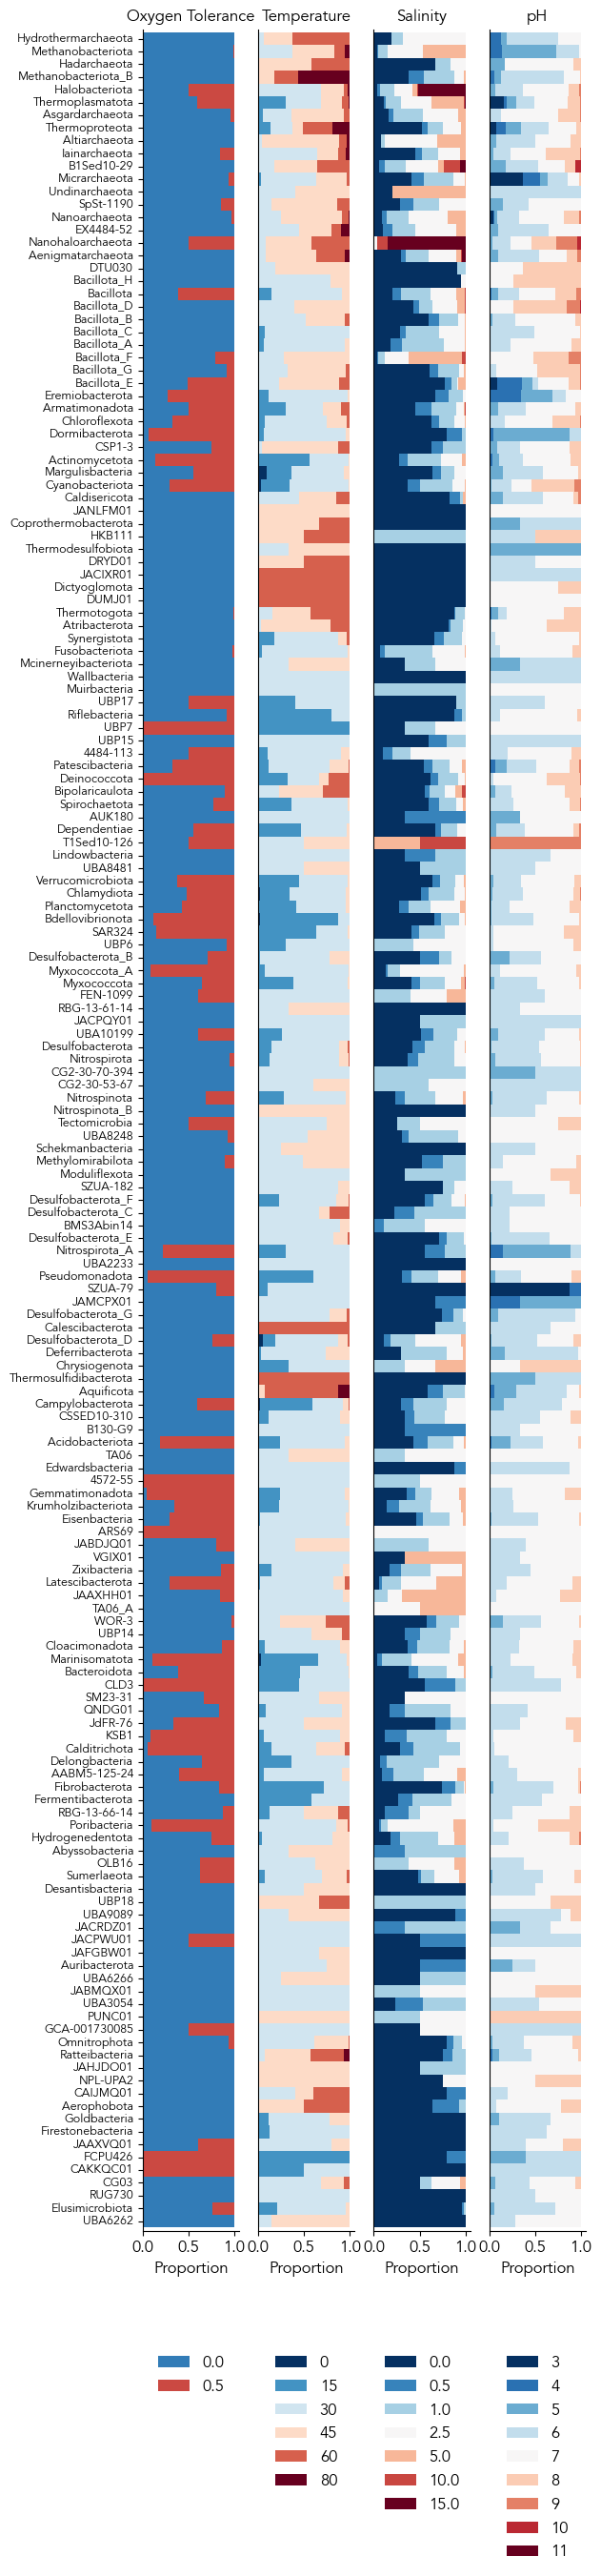

In [20]:
MIN_SPECIES_PER_PHYLUM = 1
fig, axes = plt.subplots(1,4, figsize=(6,30))

for n, target in enumerate(targets):
    ax = axes[n]
    dist_df = distribution_df_by_target(target, normalize=False)
    dist_df = dist_df[dist_df.sum(axis=1) >= MIN_SPECIES_PER_PHYLUM]
    dist_df = (dist_df.T / dist_df.sum(axis=1)).T
    dist_df = dist_df.reindex([f"p__{i}" for i in phylum_order if f"p__{i}" in dist_df.index])
    bins = bin_definitions[target]
    print(target)
    if target in ['oxygen',]:
        dist_df.columns = list(bins) #[:-1] 
        if target == 'oxygen':
            cmap = oxygen_cmap
        else:
            cmap = 'RdBu_r'
    else:
        dist_df.columns = list(bins)
        cmap = 'RdBu_r'

    dist_df.plot.barh(ax=ax, stacked=True, cmap=cmap, edgecolor='None', width=1, legend=True)
    ax.set_title(plot_formats[target.replace('_optimum', '')])
    if n == 0:
        ax.set_yticklabels([s[3:] for s in dist_df.index.tolist()], fontsize=9, rotation=0, ha='right', va='center')
        ax.legend(bbox_to_anchor=(1,0))
    else:
        ax.set_yticklabels([])
        ax.set_yticks([])

    ax.set_xticks([0,0.5,1.])
    ax.set_xlabel('Proportion')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), frameon=False)

    

In [21]:
set(gtdb_df[gtdb_df['phylum'] == 'p__Aquificota']['ncbi_species'].tolist())

{'',
 'Aquifex aeolicus',
 'Balnearium lithotrophicum',
 'Desulfurobacterium atlanticum',
 'Desulfurobacterium indicum',
 'Desulfurobacterium thermolithotrophum',
 'Hydrogenivirga caldilitoris',
 'Hydrogenobacter hydrogenophilus',
 'Hydrogenobacter thermophilus',
 'Hydrogenothermus marinus',
 'Persephonella atlantica',
 'Persephonella hydrogeniphila',
 'Persephonella marina',
 'Phorcysia thermohydrogeniphila',
 'Sulfurihydrogenibium azorense',
 'Sulfurihydrogenibium subterraneum',
 'Sulfurihydrogenibium yellowstonense',
 'Thermocrinis albus',
 'Thermocrinis minervae',
 'Thermocrinis ruber',
 'Thermovibrio ammonificans',
 'Thermovibrio guaymasensis'}

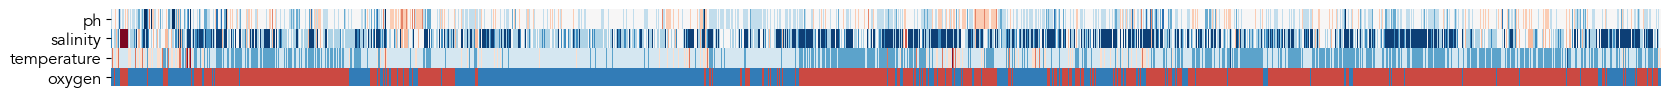

In [22]:
# Alt view  = plot of all species as heatmap
# Issue: some cells obscured / resolution too low
genome_data = df.sort_values(['domain', 'phylum', 'class','order','family','genus','species']) #.reindex(genome_ids)
C = []
for target in targets:
    bins = bin_definitions[target]
    X = genome_data[target].values
    X[X < bins[0]] = bins[0]
    ones = np.array([1] * len(X))
    X_binned = np.digitize(X, bins) / (len(bins)+1)
    C.append(X_binned)

fig, ax = plt.subplots(figsize=(20,1))
pcolor_kwargs = {
    'edgecolors' : 'None'
                }
ax.pcolor(range(len(C[0])), [0,2], [C[0], C[0]], cmap=oxygen_cmap, **pcolor_kwargs)#, edgecolor='black')#, edgecolor='white', lw=0.05)
ax.pcolor(range(len(C[0])), [2,4,6], C[1:], cmap='RdBu_r', **pcolor_kwargs)#,edgecolor='black')#, edgecolor='white', lw=0.05)
ax.set_yticks([i for i in range(8) if i % 2 == 0])
ax.set_yticklabels([target.split('_')[0] for target in targets])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_xticklabels([])
plt.show()

# Cultivation

In [23]:
training_df = pd.read_csv('../data/training_data/training_data_20231117.tsv', sep='\t', index_col=0)
training_df = training_df[['oxygen', 'ph_optimum', 'salinity_optimum', 'temperature_optimum']]

In [89]:
#mag_colors = ['steelblue', 'black', ]
cultivation_labels = ['All', 'Uncultivated', 'Cultivated', 'Uncultivated beyond Family', 'Uncultivated within Family']
#cultivation_labels = ['All', 'Uncultivated (All)', 'Cultivated', 'Uncultivated (Family+)', 'Uncultivated (Genus-Species)']
cultivation_colors = ['yellow', 'lightsteelblue', 'gray', 'black', 'orange']



is_isolate = (df['ncbi_genome_category'] == 'none')
is_novel_family = ~is_isolate & (~df['family'].isin(taxa_to_compare))
is_novel_genus = ~is_isolate & (df['family'].isin(taxa_to_compare))
cultivation_datasets = [df, df[~is_isolate], df[is_isolate], df[is_novel_family], df[is_novel_genus],
                        #df[~is_isolate & ~is_major], df[is_isolate & ~is_major], training_df.reindex(df[~is_major].index),
                       ]

for data_df, label in zip(cultivation_datasets, cultivation_labels + cultivation_labels):
    print(len(data_df)/len(df), label)
    

1.0 All
0.6810970722738202 Uncultivated
0.3189029277261798 Cultivated
0.27363160624204425 Uncultivated beyond Family
0.40746546603177597 Uncultivated within Family


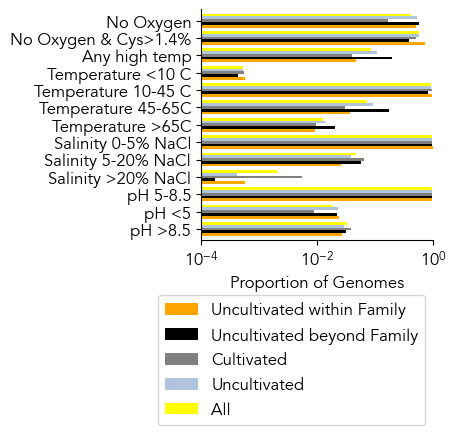

In [90]:

top_phyla = df['phylum'].value_counts().head(4).index
is_major = df['phylum'].isin(top_phyla)

is_anoxic = (df['oxygen'] <= 0.5)
indices = df[is_isolate & is_anoxic].index
median_cysteine = df_features.loc[indices, 'all_aa_C'].dropna().median()
genomes_above_median_cys =  df_features[df_features['all_aa_C'] > median_cysteine].index

data = {}
for data_df, label in zip(cultivation_datasets, cultivation_labels + cultivation_labels):
        
    is_anoxic = (data_df['oxygen'] <= 0.5)
    is_low_ph = (data_df['ph_optimum'] <= 5)
    is_high_ph = (data_df['ph_optimum'] >= 8.5)
    is_mod_ph = (data_df['ph_optimum'] > 5) & (data_df['ph_optimum'] < 8.5)
    is_low_temp = (data_df['temperature_optimum'] <= 10)
    is_mod_temp = (data_df['temperature_optimum'] >= 10) & (data_df['temperature_optimum'] < 45)
    is_high_temp = (data_df['temperature_optimum'] >= 45) & (data_df['temperature_optimum'] < 65)
    is_any_high_temp = (data_df['temperature_optimum'] >= 45)
    is_extreme_temp = (data_df['temperature_optimum'] >= 65)
    is_low_salinity = (data_df['salinity_optimum'] < 5)
    is_mod_salinity = (data_df['salinity_optimum'] >= 5) & (data_df['salinity_optimum'] < 20)
    is_high_salinity = (data_df['salinity_optimum'] >= 20)
    is_above_median_cys = np.array([idx in genomes_above_median_cys for idx in data_df.index])
    #any_extreme = (is_low_ph | is_high_ph | is_low_temp | is_high_temp | is_mod_salinity | is_high_salinity)

    n_genomes = len(data_df)

    data[label] = {
        'No Oxygen' : len(data_df[is_anoxic]) / np.sum(~data_df['oxygen'].isnull()),
        f"No Oxygen & Cys>{100*median_cysteine:.1f}%" : len(data_df[is_anoxic & is_above_median_cys]) / np.sum(~data_df['oxygen'].isnull() & is_anoxic),
        'Any high temp' : len(data_df[is_any_high_temp])/ np.sum(~data_df['temperature_optimum'].isnull()),
        'Temperature <10 C' : len(data_df[is_low_temp])/ np.sum(~data_df['temperature_optimum'].isnull()),
        'Temperature 10-45 C' : len(data_df[is_mod_temp])/ np.sum(~data_df['temperature_optimum'].isnull()),
        'Temperature 45-65C' :  len(data_df[is_high_temp])/ np.sum(~data_df['temperature_optimum'].isnull()),
        'Temperature >65C' :  len(data_df[is_extreme_temp])/ np.sum(~data_df['temperature_optimum'].isnull()),
        'Salinity 0-5% NaCl' : len(data_df[is_low_salinity])/ np.sum(~data_df['salinity_optimum'].isnull()),
        'Salinity 5-20% NaCl' : len(data_df[is_mod_salinity])/ np.sum(~data_df['salinity_optimum'].isnull()),
        'Salinity >20% NaCl' :  len(data_df[is_high_salinity])/ np.sum(~data_df['salinity_optimum'].isnull()),
        'pH 5-8.5' :  len(data_df[is_mod_ph]) / np.sum(~data_df['ph_optimum'].isnull()),
        'pH <5' :  len(data_df[is_low_ph]) / np.sum(~data_df['ph_optimum'].isnull()),
        'pH >8.5' : len(data_df[is_high_ph])/ np.sum(~data_df['ph_optimum'].isnull()),

    }


fig, ax = plt.subplots(figsize=(3,3))
#pd.DataFrame(data)[::-1].T[::-1]
pd.DataFrame(data).T[::-1].T[::-1].plot.barh(ax=ax, 
                                           #color=['gray', 'cornflowerblue'],
                                           color=cultivation_colors[::-1], 
                                           width=0.8, edgecolor='None')
ax.set_xlim(1e-4,1)
ax.set_xscale('log')
ax.set_xlabel('Proportion of Genomes')
ax.legend(bbox_to_anchor=(1,-0.2))

In [91]:
# is_anoxic = (df['oxygen'] <= 0.5)
# indices = df[is_anoxic].index
# X = df_features.loc[indices, 'all_aa_C'].dropna()
# print(X.median())
# plt.hist(X, bins=50)

pH >8.5                 0.766675
pH <5                   2.616176
pH 5-8.5                0.994243
Salinity >20% NaCl      0.075418
Salinity 5-20% NaCl     0.602816
Salinity 0-5% NaCl      1.032506
Temperature >65C        1.429968
Temperature 45-65C      3.103125
Temperature 10-45 C     0.930997
Temperature <10 C       0.936439
Any high temp           2.693920
No Oxygen & Cys>1.4%    1.134166
No Oxygen               3.233413
Name: Uncultivated / Cultivated, dtype: float64 0 Uncultivated

pH >8.5                 0.717811
pH <5                   2.693621
pH 5-8.5                0.995466
Salinity >20% NaCl      0.105054
Salinity 5-20% NaCl     0.407526
Salinity 0-5% NaCl      1.045625
Temperature >65C        0.963959
Temperature 45-65C      1.254197
Temperature 10-45 C     0.992508
Temperature <10 C       1.043534
Any high temp           1.183213
No Oxygen & Cys>1.4%    1.426274
No Oxygen               3.086030
Name: Uncultivated within Family / Cultivated, dtype: float64 1 Uncultivated w

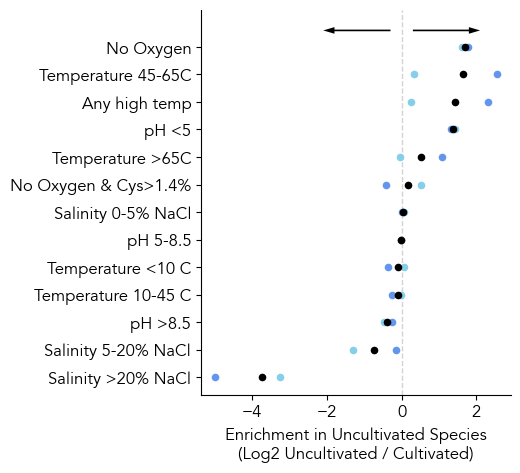

In [92]:
ratio_colors = ['black',  'skyblue', 'cornflowerblue']

fig, ax = plt.subplots(figsize=(4,5))
# 'Uncultivated beyond Family', 'Uncultivated within Family'
sers = []
for n, (numer, denom) in enumerate([('Uncultivated', 'Cultivated'),
                                    ('Uncultivated within Family', 'Cultivated'), 
                                    ('Uncultivated beyond Family', 'Cultivated')]):

    x = f"{numer} / {denom}"
    #fnumer = numer.replace(' ', '\n')
    label = numer.replace(' ', '\n')
    df_plot = pd.DataFrame(data)[::-1]
    df_plot[x] = df_plot[numer] / df_plot[denom]
    ser = df_plot[x]
    ser.name = x
    sers.append(ser)
    print(df_plot[x], n, numer)
    print()
    if n == 0:
        df_plot = df_plot.sort_values(x)
        indices = df_plot.index
    df_plot = df_plot.loc[indices]
    
    X = np.log2(df_plot[x])
    Y = range(len(X))
    
    ax.scatter(X,Y, color=ratio_colors[n], s=20, label=label, zorder=3-n)

ax.axvline(x=0, linestyle='--', color='lightgray', zorder=0)
ax.set_yticks(Y, df_plot[x].index)
#ax.set_xlim([-4,3])
ax.set_xlabel('Enrichment in Uncultivated Species\n(Log2 Uncultivated / Cultivated)')
#ax.legend(bbox_to_anchor=(0.5,-0.3), frameon=False, fontsize=11, loc='center')
#ax.legend(frameon=False, fontsize=11,bbox_to_anchor=(0.5,0.9),)
ax.arrow(-0.3, len(df_plot)-0.4, -1.5, 0, clip_on=False, width=0.06, head_width=0.24, head_length=0.3, lw=0, color='black')
ax.arrow(0.3, len(df_plot)-0.4, 1.5, 0, clip_on=False, width=0.06, head_width=0.24, head_length=0.3, lw=0, color='black')
plt.savefig("fig-3c.svg",  format="svg")
plt.show()

In [96]:
pd.DataFrame(data)

,All,Uncultivated,Cultivated,Uncultivated beyond Family,Uncultivated within Family
No Oxygen,0.412321,0.528804,0.163544,0.564697,0.504700
No Oxygen & Cys>1.4%,0.558471,0.566955,0.499887,0.372616,0.712976
Any high temp,0.084296,0.105439,0.039140,0.193487,0.046310
Temperature <10 C,0.000530,0.000519,0.000554,0.000431,0.000579
Temperature 10-45 C,0.915174,0.894042,0.960306,0.806082,0.953111
Temperature 45-65C,0.071920,0.091751,0.029567,0.173156,0.037083
Temperature >65C,0.012376,0.013688,0.009572,0.020331,0.009227
Salinity 0-5% NaCl,0.951723,0.961375,0.931108,0.943186,0.973591
Salinity 5-20% NaCl,0.046238,0.038209,0.063385,0.056642,0.025831
Salinity >20% NaCl,0.002039,0.000415,0.005507,0.000172,0.000579


In [94]:
df_ratios = pd.concat(sers,axis=1)
(df_ratios['Uncultivated beyond Family / Cultivated'] / df_ratios['Uncultivated within Family / Cultivated'])

pH >8.5                 1.169444
pH <5                   0.928435
pH 5-8.5                0.996941
Salinity >20% NaCl      0.297820
Salinity 5-20% NaCl     2.192799
Salinity 0-5% NaCl      0.968770
Temperature >65C        2.203311
Temperature 45-65C      4.669416
Temperature 10-45 C     0.845738
Temperature <10 C       0.744551
Any high temp           4.178044
No Oxygen & Cys>1.4%    0.522621
No Oxygen               1.118875
dtype: float64

(0.0, 1.0)

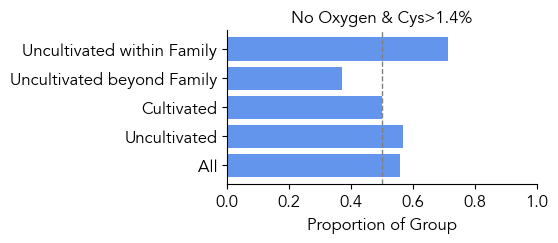

In [95]:
# 9.6% all
# 12% uncultivated
# 95% cultivated / 90% all
# 1
fig, ax = plt.subplots(figsize=(4,2))
ax.set_title('No Oxygen & Cys>1.4%')
pd.DataFrame(data).loc['No Oxygen & Cys>1.4%'].plot.barh(ax=ax, width=0.8, color='cornflowerblue')
ax.axvline(0.5, linestyle='--', color='gray')
ax.set_xlabel('Proportion of Group')
ax.set_xlim(0,1)

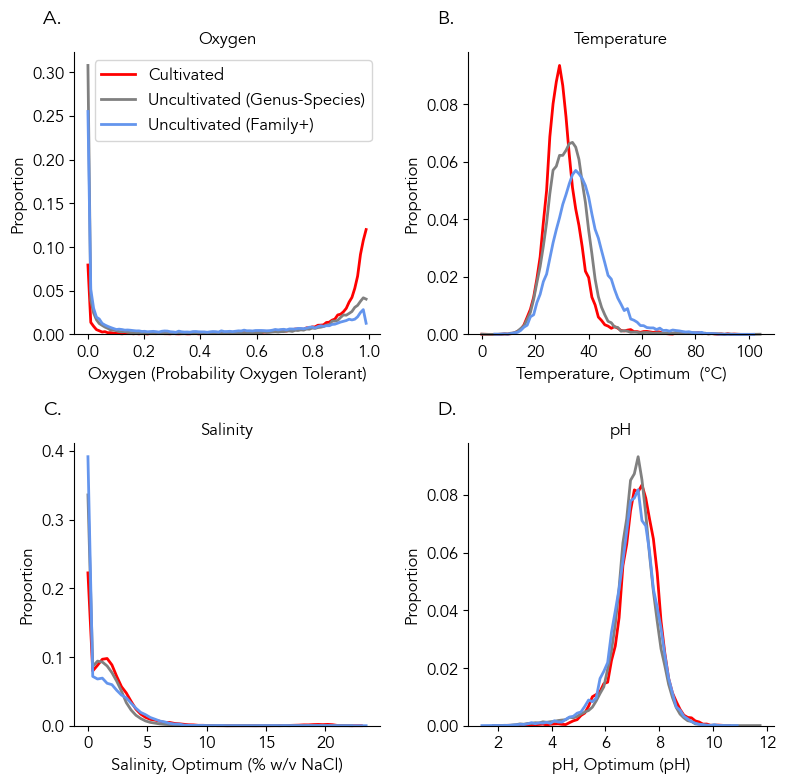

In [55]:
cultivation_labels = [ 'Cultivated',  'Uncultivated (Genus-Species)', 'Uncultivated (Family+)',]
cultivation_colors = ['red', 'gray', 'cornflowerblue', ]
cultivation_datasets = [df[is_isolate],  df[is_novel_genus], df[is_novel_family],]

def normalize_histogram(values, bins, norm = True):  
    digit_to_bin = dict(zip(range(1, len(bins)+1), list(bins) ))    
    binned_values = np.digitize(sorted(values), bins)
    counts = Counter(binned_values)
    if norm is True:
        counts = {k : v / len(binned_values) for k, v in counts.items()}
    
    binned_ser = pd.Series(counts).sort_index()
    X = binned_ser.index.map(digit_to_bin)
    Y = binned_ser.values
    return X, Y
    
fig, axes = plt.subplots(2,2,figsize=(8,8))
axl = axes.flatten()

conditions = ['oxygen', 'temperature', 'salinity', 'ph']
for n, condition in enumerate(conditions):
    x = rename_condition_to_variable(condition)
    for m, (df_plot, color, label) in enumerate(zip(cultivation_datasets, cultivation_colors, cultivation_labels)):
        ax = axl[n]
        data = df_plot[~df_plot[x].isnull()]

        X = data[f"{x}"].values
        if x == 'oxygen':
            bin_min, bin_max = 0, 1
        if x == 'salinity_optimum':
            bin_min, bin_max, bin_step = 0,40,0.25
        if x == 'ph_optimum':
            bin_min, bin_max, bin_step = 0, 14, 0.25
        if x == 'temperature_optimum':
            bin_min, bin_max, bin_step = 0,120,3

        bins = np.linspace(bin_min, bin_max, 100)
        X, Y = normalize_histogram(X, bins, norm=True,)
        
        ax.plot(X, Y, color=color, label=label,  clip_on=False, lw=2)
        ax.set_xlabel(f"{plot_formats[x]} ({units[condition]})")
        ax.set_ylabel('Proportion')
        ax.set_title(plot_formats[condition])
        #ax.set_yscale('log')
        if n == 0:
            ax.legend()
            
for n, ax in enumerate(axl):    
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.text(-0.1, 1.1, f"{string.ascii_uppercase[n]}.", transform=ax.transAxes,  size=14)

plt.tight_layout()

In [34]:
df[is_novel_family & (df['temperature_optimum'] > 45)][['phylum', 'class']].value_counts().head(20)

phylum                class               
p__Nanoarchaeota      c__Nanoarchaeia         536
p__Patescibacteria    c__Paceibacteria        349
p__Bacillota_A        c__Clostridia           264
p__Chloroflexota      c__Anaerolineae         201
                      c__Dehalococcoidia      157
p__Bacillota          c__Bacilli              151
p__Omnitrophota       c__Koll11               144
p__Patescibacteria    c__Microgenomatia       140
                      c__ABY1                 140
p__Thermoplasmatota   c__Thermoplasmata       131
p__Aenigmatarchaeota  c__Aenigmatarchaeia     121
p__Thermoproteota     c__Bathyarchaeia        103
p__Asgardarchaeota    c__Lokiarchaeia          65
p__Micrarchaeota      c__Micrarchaeia          59
p__Bacillota_G        c__Limnochordia          53
p__Bacillota_D        c__Dethiobacteria        49
p__Thermoplasmatota   c__E2                    45
p__Methylomirabilota  c__Methylomirabilia      41
p__Thermoproteota     c__Nitrososphaeria_A     38
p__Bact

In [35]:
df[is_novel_genus & (df['temperature_optimum'] > 45)][['family', 'genus']].value_counts().head(50)

family                        genus                    
f__Erysipelotrichaceae        g__UBA636                    29
f__Methanoculleaceae          g__Methanoculleus            24
f__Methanobacteriaceae        g__Methanobrevibacter_A      19
f__Rikenellaceae              g__Alistipes                 16
f__Erysipelotrichaceae        g__Bulleidia                 16
f__GWC2-37-13                 g__GWC2-37-13                14
f__Methanobacteriaceae        g__Methanobacterium_A        11
f__Lachnospiraceae            g__Acetatifactor              9
f__Methanobacteriaceae        g__Methanobacterium           9
f__Aquificaceae               g__Hydrogenivirga             9
f__UBA233                     g__PALSA-986                  9
f__Bipolaricaulaceae          g__Bipolaricaulis             8
f__Erysipelotrichaceae        g__RUG521                     8
f__Thermococcaceae            g__Thermococcus               8
f__Sedimentibacteraceae       g__Sedimentibacter            8
f__Methanoregu

## Some specifics

In [36]:

df[df['genus'].str.contains("CAJXPB0")]
df[df['phylum'].str.contains("p__T1Sed10-126")] #.groupby('phylum')['salinity_optimum'] #.mean()
#df[df['family'].str.contains("f__PWEA01")].groupby('family')['salinity_optimum'].mean()
np.mean(df[df['genus'] == 'g__Bifidobacterium']['oxygen'] > 0.5)

0.984251968503937

# Supplement

## More Distributions

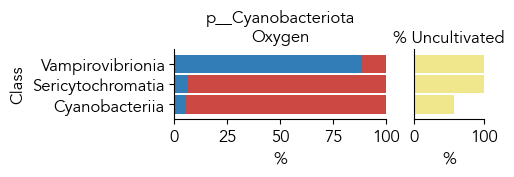

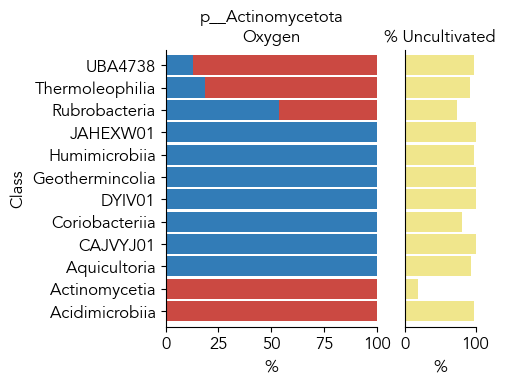

In [69]:
def plot_distribution_w_uncultivated(axes, dist_df, rank, taxon):
    

    ax = axes[0]
    bins = bin_definitions[target]
    if target in ['oxygen', 'ph_optimum']:
        #dist_df.columns = list(bins)
        #cmap = 'twilight'
        if target == 'oxygen':
            cmap = oxygen_cmap
        else:
            cmap = 'RdBu_r'
    else:
        dist_df.columns = list(bins)
        cmap = 'RdBu_r'
    
    dist_df.plot.barh(ax=ax, stacked=True, cmap=cmap, edgecolor='None', width=0.9, legend=False)
    ax.set_yticklabels([idx.replace('c__', '').replace('o__', '') for idx in dist_df.index])
    ax.set_ylabel(rank.capitalize())
    ax.set_title(taxon+'\n'+plot_formats[target])
    ax.set_xlabel('%')
    
    ax = axes[1]
    isolate_df = df[df[rank].isin(dist_df.index)].copy()
    isolate_df['is_isolate'] = (isolate_df['ncbi_genome_category'] == 'none')
    isolate_df = isolate_df[[rank, 'is_isolate']].value_counts().to_frame().reset_index()
    isolate_df = pd.pivot(isolate_df, index=rank, columns='is_isolate').fillna(0).rename(columns={False : 'Uncultivated', True : 'Cultivated'})
    #isolate_df = isolate_df[rank, 'is_isolate'].value_counts() #[targets].mean().reset_index()
    isolate_df = 100 *  (1-(isolate_df.T / isolate_df.sum(axis=1)).T)
    isolate_df = isolate_df.T[::-1].T
    isolate_df.plot.barh(ax=ax, stacked=True, color=['khaki', 'white'], edgecolor='None', width=0.9, legend=False)
    ax.set_yticks([])
    ax.set_title('% Uncultivated')
    ax.set_ylabel('')
    for ax in axes:
        ax.set_xlabel('%')
        ax.set_xlim([0,100])
    return  axes
    
for taxon in ['p__Cyanobacteriota', 'p__Actinomycetota']: #, 'p__Asgardarchaeota',]:
    rank = 'class'
    target = 'oxygen'
    dist_df = distribution_df_by_target(target, df=df[df['phylum'] == taxon], taxonomic_level=rank, normalize=True)
    dist_df = 100 * dist_df

    fig, axes = plt.subplots(1,2, figsize=(4,0.3*dist_df.shape[0]), gridspec_kw={'width_ratios' : (3,1)})

    axes = plot_distribution_w_uncultivated(axes, dist_df, rank, taxon)


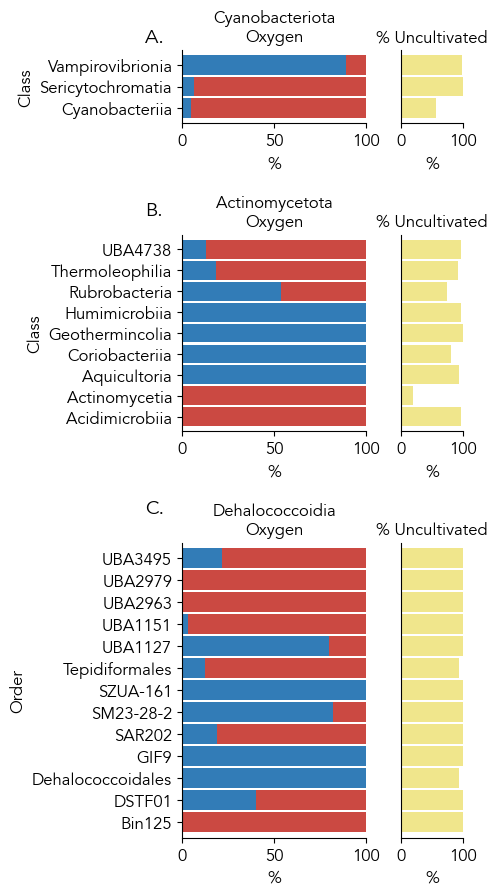

In [80]:
import string

abbrev_to_level = {'p' : 'phylum', 'c' : 'class'}
fig, axes = plt.subplots(3,2, figsize=(5,0.7*dist_df.shape[0]), gridspec_kw={'width_ratios' : (3,1), 'height_ratios' : (3,8,12)})

rank = 'order'
for n, (taxon, target, rank) in enumerate([
    ('p__Cyanobacteriota', 'oxygen', 'class' ),
    ('p__Actinomycetota', 'oxygen', 'class'),
    ('c__Dehalococcoidia', 'oxygen', 'order'),
                   #   ('p__Eremiobacterota', 'ph_optimum', 'class'),
                     ]):

    
    level = abbrev_to_level[taxon.split('__')[0]]
    dist_df = distribution_df_by_target(target, df=df[df[level] == taxon], taxonomic_level=rank, normalize=False)
    
    dist_df = dist_df[dist_df.sum(axis=1) >= 10]
    dist_df = (dist_df.T / dist_df.sum(axis=1)).T
    dist_df = 100 * dist_df
    
    

    plot_distribution_w_uncultivated(axes[n], dist_df, rank, taxon.replace('p__', '').replace('c__', ''))
    ax = axes[n][0]
    ax.text(-0.2, 1.1, f"{string.ascii_uppercase[n]}.", transform=ax.transAxes,  size=14)


plt.tight_layout(pad=1)

## Novel 

In [130]:
#for target, genomes in novel_for_target.items():

target = 'salinity_optimum'
novel_genomes = novel_for_target[target]

novel_counts = df.loc[novel_genomes]['phylum'].value_counts()
novel_counts.name = 'novel'

counts = df['phylum'].value_counts()
counts.name = 'all'

novel_df = pd.concat([counts, novel_counts], axis=1)
novel_df['fraction'] = novel_df['novel'] / novel_df['all']
novel_df[novel_df['all'] >= 10].sort_values('fraction', ascending=False).head(20)

,all,novel,fraction
phylum,,,
p__SZUA-79,41,39.0,0.951220
p__Fusobacteriota,110,65.0,0.590909
p__Nanohaloarchaeota,26,15.0,0.576923
p__Methanobacteriota,229,113.0,0.493450
p__Micrarchaeota,244,115.0,0.471311
p__Ratteibacteria,28,12.0,0.428571
p__Nanoarchaeota,722,298.0,0.412742
p__Aquificota,84,34.0,0.404762
p__Aenigmatarchaeota,131,47.0,0.358779


## Min > Max

In [105]:
for n, condition in enumerate(['temperature', 'ph', 'salinity']):
    ax = axes[n]
    x = f'{condition}_min'
    y = f'{condition}_max'
    z = f'{condition}_optimum'

    filter = (optima_df[z] > optima_df[y]) | (optima_df[x] > optima_df[y])
    print(condition, np.sum(filter) / len(optima_df))

temperature 0.00018858139644524068
ph 0.00045966715383527414
salinity 0.06660459195700344


In [107]:
np.sum(filter), len(optima_df)

(5651, 84844)

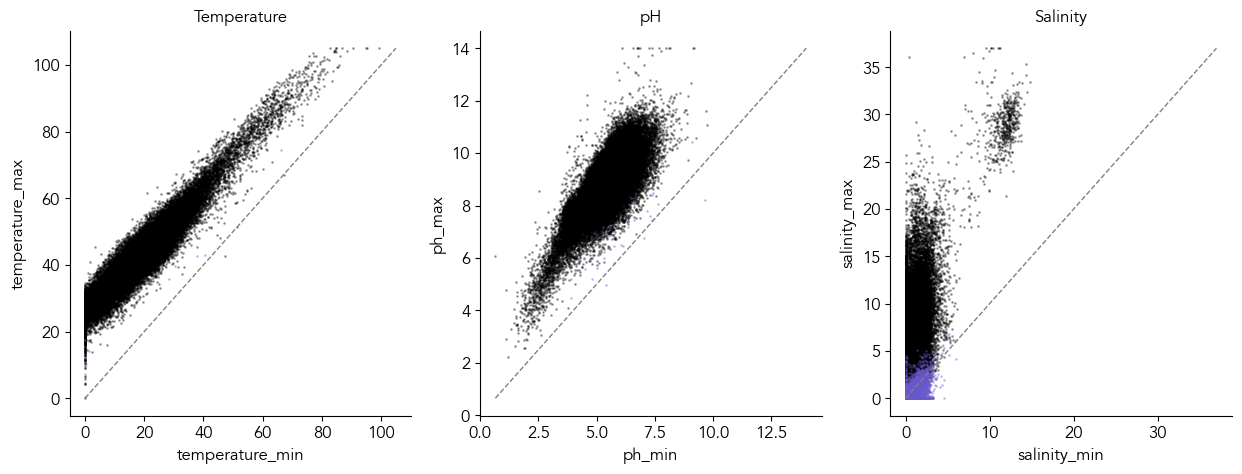

In [108]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

for n, target_type in enumerate(['temperature', 'ph', 'salinity']):
    ax = axes[n]
    x = f'{target_type}_min'
    y = f'{target_type}_max'
    z = f'{target_type}_optimum'

    filter = optima_df[z] > optima_df[y]
    X = optima_df[x].values
    Y = optima_df[y].values
    ax.scatter(X[~filter], Y[~filter], s=1, alpha=0.3)
    ax.scatter(X[filter], Y[filter], s=1, alpha=0.3)
    ax.plot([X.min(), Y.max()], [X.min(), Y.max()], linestyle='--', color='gray')
    ax.set_title(plot_formats[target_type])
    ax.set_xlabel(x)
    ax.set_ylabel(y)


In [98]:
target_type = 'salinity'
x = f'{target_type}_min'
y = f'{target_type}_max'
z = f'{target_type}_optimum'
print(len(optima_df[(optima_df[y] <= optima_df[x]) | (optima_df[y] <= optima_df[z]) ]) / len(optima_df[~optima_df[y].isnull()]))
#print(len(optima_df[optima_df[y] < optima_df[z]]) / len(optima_df[~optima_df[y].isnull()]))
df.loc[optima_df[optima_df[y] < optima_df[x]].index, ['class']].value_counts().head(50)

0.16025882796662108


class                    
c__Clostridia                1373
c__Cyanobacteriia             345
c__Bacteroidia                340
c__Bacilli                    322
c__Vampirovibrionia           155
c__Gammaproteobacteria        127
c__Campylobacteria             77
c__Alphaproteobacteria         70
c__Planctomycetia              68
c__Polyangia                   64
c__Microgenomatia              50
c__Thermodesulfovibrionia      48
c__Lentisphaeria               41
c__Aquificae                   39
c__ABY1                        38
c__Leptospirae                 36
c__Paceibacteria               36
c__Methanomicrobia             36
c__Spirochaetia                33
c__Desulfuromonadia            33
c__Verrucomicrobiae            33
c__Actinomycetia               29
c__Syntrophia                  28
c__Coriobacteriia              24
c__Blastocatellia              24
c__Anaerolineae                21
c__Nanoarchaeia                20
c__Eremiobacteria              20
c__UBA9042            

In [104]:
df[df['genus'] == 'g__Pelagibacter'][['salinity_optimum', 'salinity_max']].describe() 

,salinity_optimum,salinity_max
count,855.000000,855.000000
mean,1.962961,8.366205
std,1.050486,2.515657
min,0.000000,0.000000
25%,1.158676,6.725059
50%,2.020921,8.580500
75%,2.673811,10.056036
max,5.140003,16.352884


In [102]:
taxlevels = ['family', 'phylum']
ser_some = df.loc[optima_df[optima_df[y] <= optima_df[x]].index, taxlevels].value_counts()
ser_some.name = 'filtered'
ser_all = df.loc[:, taxlevels].value_counts()
ser_all.name = 'all'

counts_df = pd.concat([ser_some, ser_all], axis=1)
counts_df['f_filtered'] = counts_df['filtered'] / counts_df['all']
counts_df.loc[counts_df['all'] > 5].sort_values('f_filtered', ascending=False).head(30).style.background_gradient(cmap='Blues')

,,filtered,all,f_filtered
family,phylum,,,
f__UBA10092,p__Patescibacteria,8.000000,8,1.000000
f__NBVN01,p__Thermoproteota,15.000000,15,1.000000
f__LBFQ01,p__WOR-3,6.000000,6,1.000000
f__UBA9628,p__Elusimicrobiota,38.000000,38,1.000000
f__Leptolyngbyaceae,p__Cyanobacteriota,38.000000,38,1.000000
f__SpSt-205,p__Bacteroidota,6.000000,6,1.000000
f__GWC2-42-12,p__Patescibacteria,8.000000,8,1.000000
f__Phormidiaceae_A,p__Cyanobacteriota,8.000000,8,1.000000
f__Chlamydiaceae,p__Chlamydiota,23.000000,23,1.000000
